<a href="https://colab.research.google.com/github/Farmhouse121/Wilmott-Articles/blob/main/Asymmetric_Response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from warnings import filterwarnings ; filterwarnings("ignore",category=RuntimeWarning) # I don't care
print("Installing yfinance and arch and getting the data...")
!pip install arch 1>/dev/null
!pip install yfinance 1>/dev/null
from yfinance import download
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from datetime import datetime
zero,one,two,five,ten,hundred=0e0,1e0,2e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

# import arch classes
from arch.univariate import ConstantMean,ARX,GeneralizedError,Normal,GARCH
from arch.typing import Float64Array

# change the constraints for GeneralizedError
class GeneralizedError2(GeneralizedError):
    """Version of the GED with bounds on fit adjusted to include all feasible distributions (GED is valid for all positive nu values)."""
    def bounds(self,*args)->list[tuple[float,float]]:
        """Revised bounds."""
        return [(0e0,1e2)]
    
    def constraints(self,*args)->tuple[Float64Array,Float64Array]:
        return np.array([[1], [-1]]), np.array([self.bounds()[0][0],-self.bounds()[0][1]])

# change the constraints for GARCH
class GARCH2(GARCH):
    """Version of GARCH with constraints modified to be more relaxed, leads to models that don't bind on constraints."""
    def bounds(self,resids:Float64Array)->list[tuple[float,float]]:
        """Modify bounds to be more relaxed."""
        v=float(np.mean(abs(resids)**self.power))
        bounds=[(1e-8*v,ten*v)]
        bounds.extend([(-one,two)]*(self.p+self.o+self.q))
        return bounds

    def constraints(self,*args)->tuple[Float64Array,Float64Array]:
        """Modify constraints to permit negative values for A and D etc."""
        a,b=super(GARCH2,self).constraints()
        b[1:(self.p+self.o+1)]=-one
        return a,b

# get the daily returns of the S&P 500 
SPX=download('^GSPC','1928-01-01').dropna()
SPX['Return']=SPX['Adj Close'].pct_change()*hundred
SPX.index=pd.DatetimeIndex(SPX.index).to_period('B')
SPX.dropna(inplace=True)
SPX.loc[SPX["Volume"]==0,"Volume"]=np.nan
SPX

Installing yfinance and arch and getting the data...
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,NaN,-0.225230
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,NaN,-0.959368
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,NaN,0.626784
1928-01-09,17.500000,17.500000,17.500000,17.500000,17.500000,NaN,-0.906001
1928-01-10,17.370001,17.370001,17.370001,17.370001,17.370001,NaN,-0.742852
...,...,...,...,...,...,...,...
2023-05-24,4132.959961,4132.959961,4103.979980,4115.240234,4115.240234,3.739160e+09,-0.731860
2023-05-25,4155.709961,4165.740234,4129.729980,4151.279785,4151.279785,4.147760e+09,0.875758
2023-05-26,4156.160156,4212.870117,4156.160156,4205.450195,4205.450195,3.715460e+09,1.304909


Fitting GARCH with GED for 21st Century.
GJR (Partially Asymmetric) model:
                                  AR - GARCH Model Results                                 
Dep. Variable:                             Return   R-squared:                       0.004
Mean Model:                                    AR   Adj. R-squared:                  0.003
Vol Model:                                  GARCH   Log-Likelihood:               -6686.98
Distribution:      Generalized Error Distribution   AIC:                           13386.0
Method:                        Maximum Likelihood   BIC:                           13425.1
                                                    No. Observations:                 5030
Date:                            Wed, May 31 2023   Df Residuals:                     5028
Time:                                    16:58:25   Df Model:                            2
                                  Mean Model                                  
                 coef    s

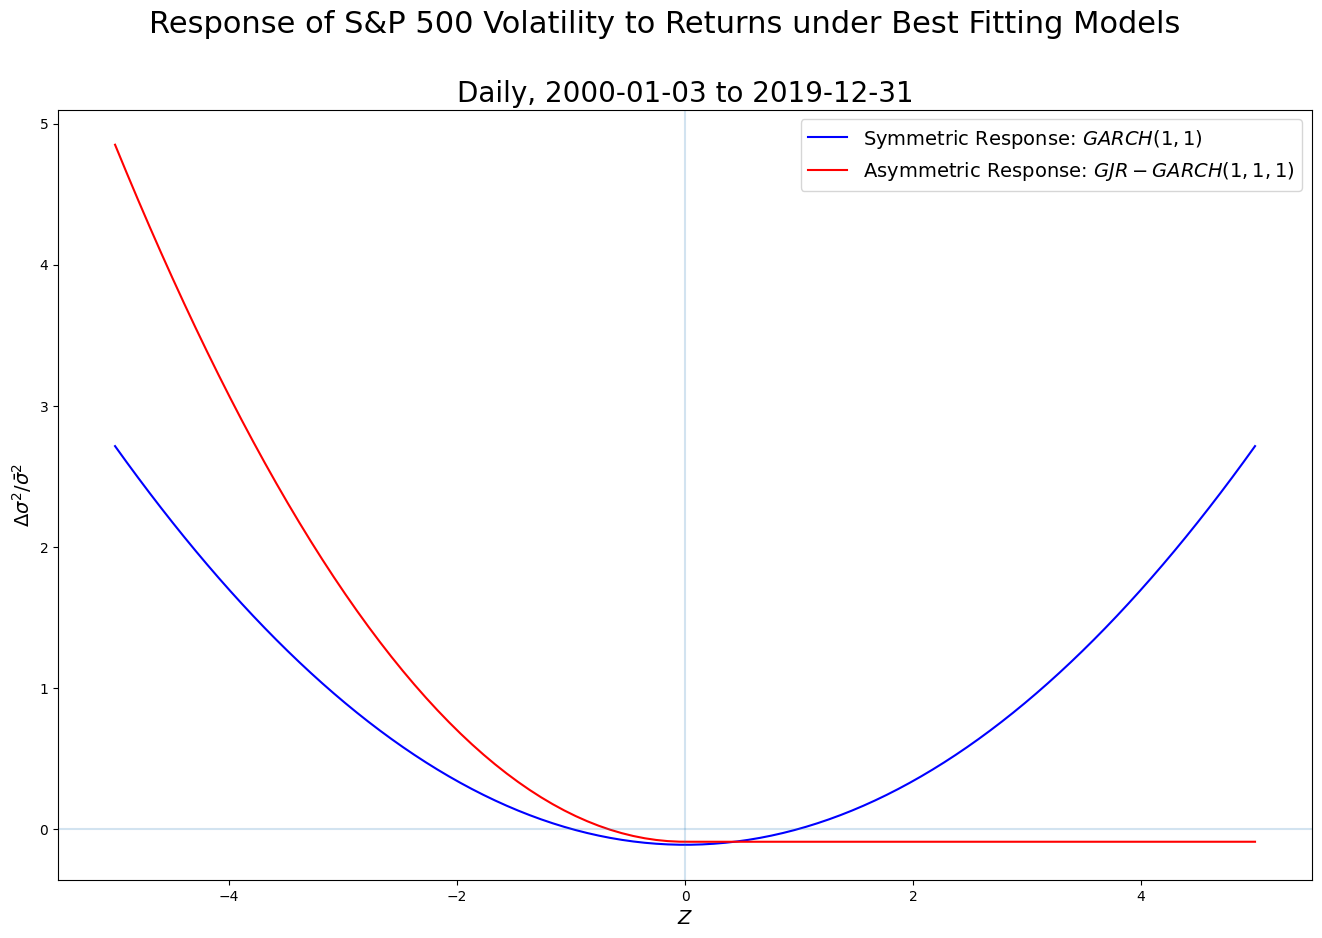

In [14]:
# fit symmetric and asymmetric GARCH models using arch package GARCH process and extended GED distribution
print("Fitting GARCH with GED for 21st Century.")
from scipy.stats import chi2 as density

fyear,lyear=2000,2019
sym = ARX(SPX.loc[(SPX.index.year>=fyear)&(SPX.index.year<=lyear),"Return"],lags=[1])
sym.volatility = GARCH(1, 0, 1)
sym.distribution = GeneralizedError()
sym_fit=sym.fit(update_freq=0,disp='off',show_warning=False)
print("GJR (Partially Asymmetric) model:\n",sym_fit.summary())

gjr = ARX(SPX.loc[(SPX.index.year>=2000)&(SPX.index.year<=2019),"Return"],lags=[1])
gjr.volatility = GARCH(1, 1, 1)
gjr.distribution = GeneralizedError2()
gjr_fit=gjr.fit(update_freq=0,disp='off',show_warning=False)
print("Symmetric model:\n",gjr_fit.summary())

print("Maximum Likelihood Ratio Test for X^2(1)=%g p-Value=%g." % (
    gjr_fit.loglikelihood-sym_fit.loglikelihood,
    one-density(gjr_fit.num_params-sym_fit.num_params).cdf(gjr_fit.loglikelihood-sym_fit.loglikelihood)
))

figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("Response of S&P 500 Volatility to Returns under Best Fitting Models",fontsize=22)
plot.set_title("Daily, %s to %s" % (SPX[SPX.index.year>=fyear].index[0],SPX[SPX.index.year<=lyear].index[-1]),fontsize=20)
z=np.linspace(-five,five,100)
p=np.where(SPX["Return"]<0,one,zero).sum()/np.where(SPX["Return"].notna(),one,zero).sum()
print("Proportion of negative returns: %f %%" % (p*hundred))
sr=(-sym_fit.params['alpha[1]'])+sym_fit.params['alpha[1]']*z**2

ar=(-gjr_fit.params['alpha[1]']-gjr_fit.params['gamma[1]']*p)+gjr_fit.params['alpha[1]']*z**2+gjr_fit.params['gamma[1]']*np.where(z<zero,z**2,zero)
plot.plot(z,sr,'b-',label='Symmetric Response: $GARCH(1,1)$')
plot.plot(z,ar,'r-',label='Asymmetric Response: $GJR-GARCH(1,1,1)$')
plot.set_xlabel("$Z$",fontsize=14)
plot.set_ylabel("$\\Delta\\sigma^2/\\bar{\\sigma}^2$",fontsize=14)
plot.axhline(alpha=0.2)
plot.axvline(alpha=0.2)
plot.legend(fontsize=14)
figure.savefig("response.png",bbox_inches='tight',dpi=300);

Fitting model with GED innovations year by year.


  0%|          | 0/95 [00:00<?, ?it/s]

,mu,phi,C,A,B,D,kappa,flag
year,,,,,,,,
1928,0.198380,0.038395,0.292385,-0.064338,0.559777,0.259446,0.705451,0.0
1929,0.155379,-0.036879,0.311590,-0.153965,0.654138,0.772929,0.778678,0.0
1930,-0.004093,-0.128313,0.129154,-0.078530,0.884569,0.261024,0.552764,0.0
1931,-0.371953,-0.130452,0.124957,-0.002817,0.914775,0.172350,0.685360,0.0
1932,-0.138676,0.021683,1.207941,0.079276,0.783316,0.068240,0.620481,0.0
...,...,...,...,...,...,...,...,...
2018,0.019746,0.005182,0.024204,-0.062655,0.885063,0.288798,0.800583,0.0
2019,0.102948,-0.048313,0.040310,-0.022850,0.761414,0.362604,0.707258,0.0
2020,0.233274,-0.220349,0.092422,0.230360,0.689369,0.160543,0.788139,0.0


t Test for Mean of 0.5 for kappa: t = 8.72, p = 1.13435e-13 (all data).


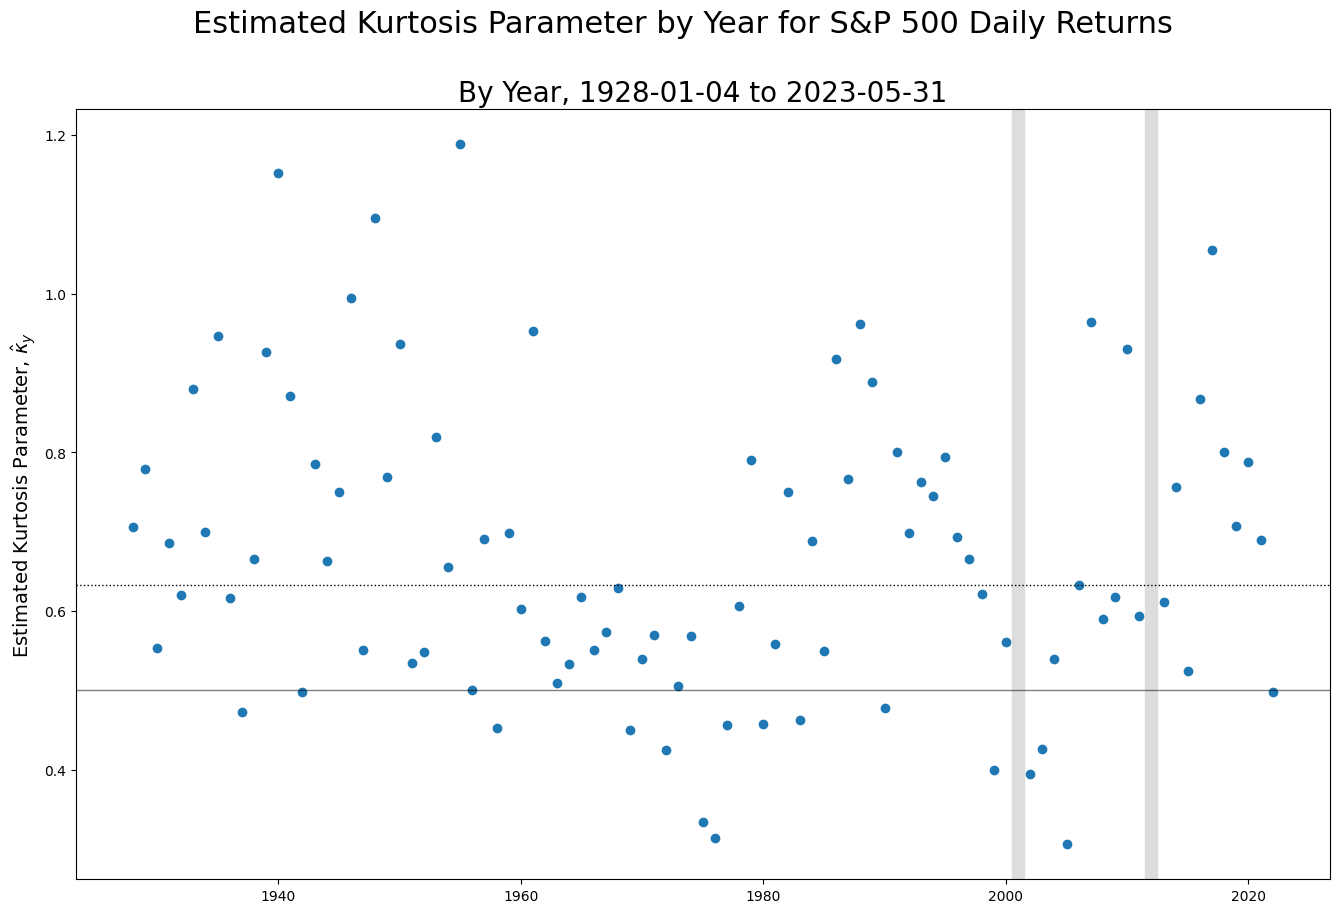

In [4]:
 # fit a GARCH model using arch package
print("Fitting model with GED innovations year by year.")
from tqdm.notebook import tqdm
from scipy.stats import ttest_1samp as t_test
results=pd.DataFrame({"year":[],"mu":[],"phi":[],"C":[],"A":[],"B":[],"D":[],"kappa":[],"flag":[]}).set_index("year")
results.index=pd.DatetimeIndex(results.index).to_period('Y')

for year in tqdm(range(SPX.index[0].year,SPX.index[-1].year)):
    model = ARX(SPX.loc[SPX.index.year==year,"Return"],lags=[1])
    model.volatility = GARCH2(1, 1, 1)
    model.distribution = GeneralizedError2()
    fit=model.fit(update_freq=0,disp='off',show_warning=False)
    mu,phi,C,A,D,B,nu=tuple(fit.params)    
    
    if fit.convergence_flag==0:
        results=pd.concat([results,pd.DataFrame({"year":[year],"mu":[mu],"phi":[phi],"C":[C],"A":[A],"B":[B],"D":[D],"kappa":[one/nu],"flag":[fit.convergence_flag]}).set_index("year")])
        
    else:
        results.loc[year,"flag"]=fit.convergence_flag

display(results)

figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
results[results["flag"]==zero]["kappa"].plot(ax=plot,style='o')
plot.set_xlabel(None)
plot.set_ylabel("Estimated Kurtosis Parameter, $\\hat{\\kappa}_y$",fontsize=14)
figure.suptitle("Estimated Kurtosis Parameter by Year for S&P 500 Daily Returns",fontsize=22)
plot.set_title("By Year, %s to %s" % (SPX.index[0],SPX.index[-1]),fontsize=20)
plot.axhline(half,color='black',linewidth=1,alpha=0.5)
plot.axhline(results["kappa"].median(),color='black',linestyle=':',linewidth=1)

for y in results[results["flag"]>zero].index:
    plot.axvspan(y-half,y+half,color='#DDDDDD',edgecolor=None)

figure.savefig("kappa.png",dpi=300,bbox_inches='tight')
print("t Test for Mean of %g for kappa: t = %.2f, p = %g (all data)." % ((half,)+t_test(results[results["flag"]==zero]["kappa"],half)))

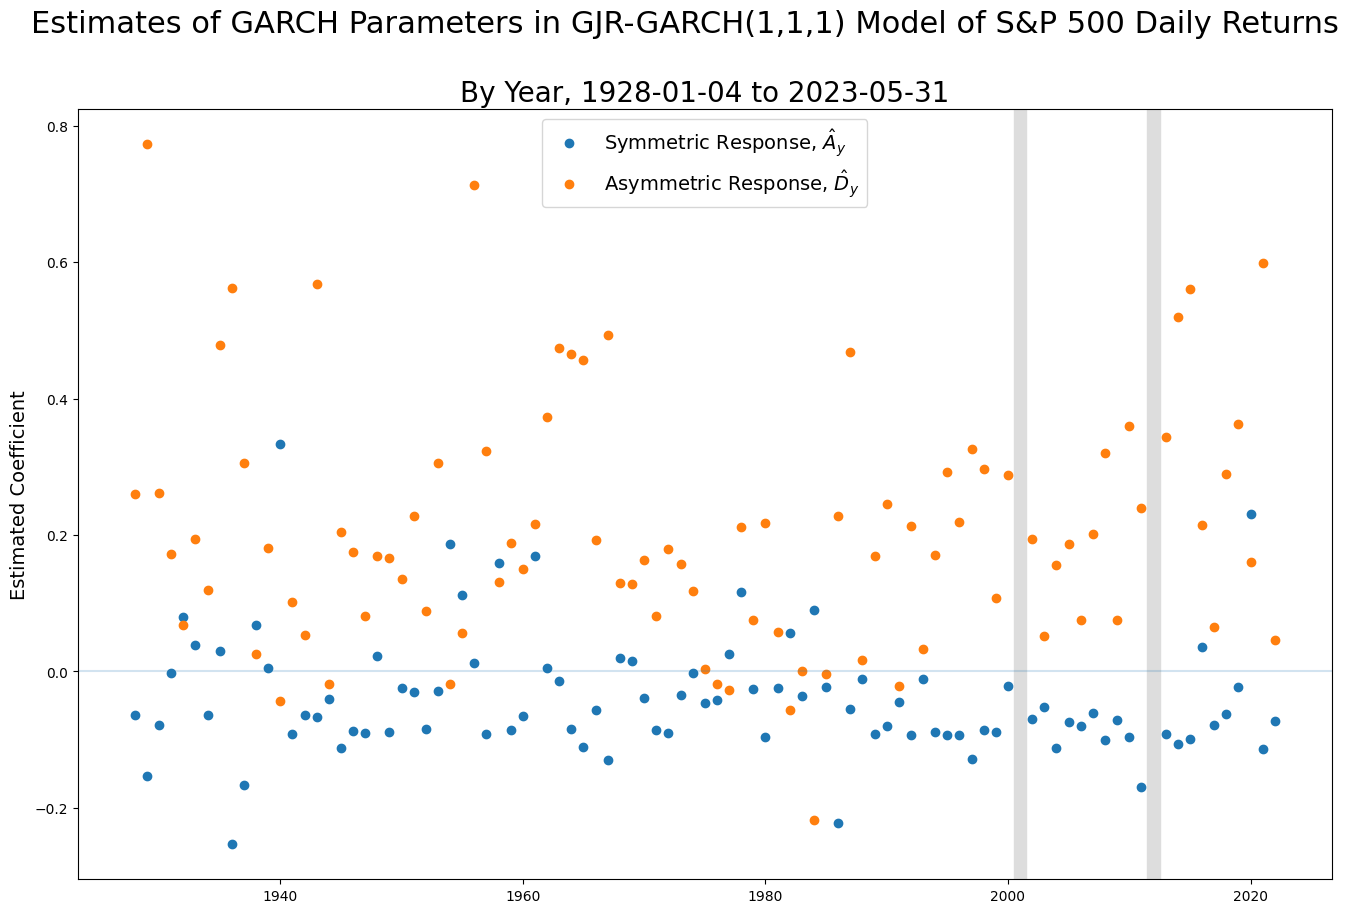

In [5]:
figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("Estimates of GARCH Parameters in GJR-GARCH(1,1,1) Model of S&P 500 Daily Returns",fontsize=22)
plot.set_title("By Year, %s to %s" % (SPX.index[0],SPX.index[-1]),fontsize=20)

results[["A","D"]].plot(ax=plot,style="o")
plot.legend(["Symmetric Response, $\\hat{A}_y$","Asymmetric Response, $\\hat{D}_y$"],fontsize=14)
plot.axhline(zero,alpha=0.2);

for y in results[results["A"].isna()].index:
    plot.axvspan(y-half,y+half,color='#DDDDDD',edgecolor=None)
    
plot.set_xlabel(None)
plot.set_ylabel("Estimated Coefficient",fontsize=14)
figure.savefig("AD.png",dpi=300,bbox_inches='tight');

Measured Correlation Between 'A' and 'D' Estimates -39.3328 % with Standard Error 10.4257 %.


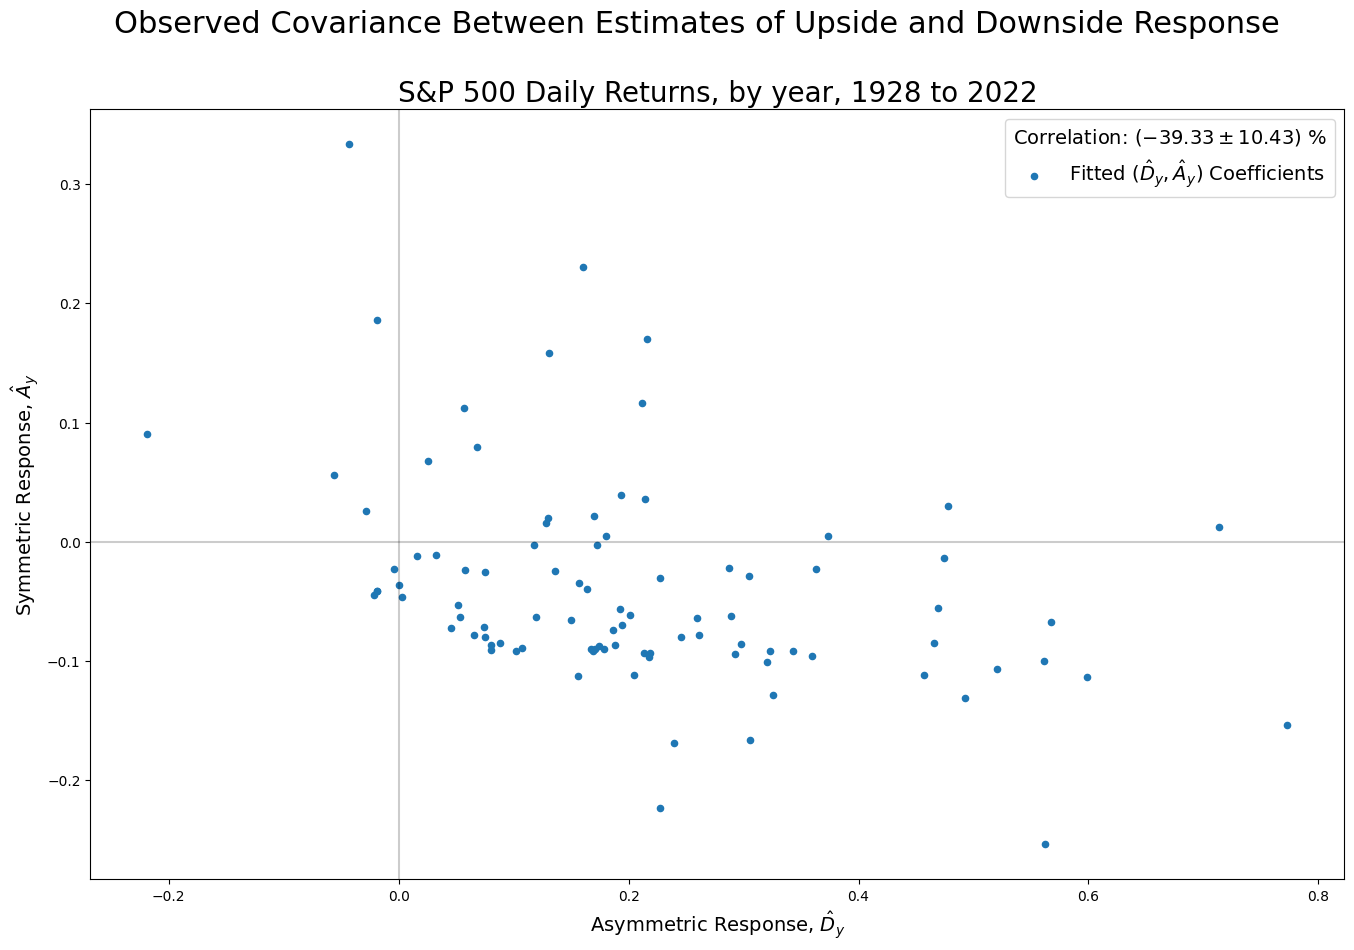

In [6]:
rho,rho_se=results[["A","D"]].corr().iloc[0,1]*hundred,hundred/np.sqrt(results[["A","D"]].shape[0]-3e0)

print("Measured Correlation Between 'A' and 'D' Estimates %g %% with Standard Error %g %%." % (rho,rho_se))

figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("Observed Covariance Between Estimates of Upside and Downside Response",fontsize=22)
plot.set_title("S&P 500 Daily Returns, by year, %s to %s" % (results.index[0],results.index[-1]),fontsize=20)
results.plot.scatter("D","A",ax=plot,label="Fitted $(\\hat{D}_y,\\hat{A}_y)$ Coefficients")
plot.set_xlabel("Asymmetric Response, $\\hat{D}_y$",fontsize=14)
plot.set_ylabel("Symmetric Response, $\\hat{A}_y$",fontsize=14)
plot.axhline(alpha=0.2,color='black')
plot.axvline(alpha=0.2,color='black')

if type(model.volatility)==GARCH:
    x=np.array([1.2*results["D"].min(),-2.2*results["D"].min()])
    y=-x
    plot.plot(x,y,alpha=0.5,color="C1",label="Regression Constraint $\\hat{A}_y+\\hat{D}_t$>=$0$")
    
plot.legend(fontsize=14,title="Correlation: $(%.2f\\pm%.2f)$ %%" % (rho,rho_se),title_fontsize=14);